In [6]:
#import necessary modules
import matplotlib.pyplot as plt
import numpy as np
from pandas import HDFStore
import os
import sys
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import csv



In [11]:
#files and folders
folderdir = '/scr2/shionmu/matchfiledata/20230725/'
lcfiledir = 'lcfolder' #insert light curve directory!
#coordinate identifiers. matches input coordinates to matchfile.
sqcoordfile = '/home/shionmu/sq_fields.csv' #file location of sq_fields.csv
coordfile = '/Users/shionmurakawa/fieldcoords.csv' #file location of fieldcoords.csv

In [8]:
#set your RA, DEC, and Threshold radius
ra = #ra in degrees here
dec = #dec in degrees here
thresh = #thresh in arcsec here
thresh = thresh * u.arcsec

In [9]:
#find fields with specified coordinates within 5 degrees
out = []
with open(coordfile, 'r') as f:
    csvreader = csv.DictReader(f)
    for row in csvreader:
        if abs(ra-float(row['ra'])) <= 5 and abs(dec-float(row['dec'])) <= 5:
            out.append(row['field'])
            print(f"found coordinate in field {row['field']}.")

print(f'found {len(out)} fields with coord')

found coordinate in field 1029.
found coordinate in field 1030.
found coordinate in field 1103.
found coordinate in field 1104.
found 4 fields with coord


In [12]:
#make the lightcurve folder if it does not already exist
if not os.path.exists(lcfiledir):
    os.makedirs(lcfiledir)

In [13]:
#search for coordinate in each subquadrant file
fieldsource = None
quadsource = None
subquadsource = None
sfound = False
with open(sqcoordfile, 'r') as f:
    csvreader = csv.DictReader(f)
    for row in csvreader:
        if row['field'] in out:
            print('searching f %s q %s sq %s for coordinate'%(row['field'], row['quad'], row['subquad']))
            if ra > float(row['raedge1']) and ra < float(row['raedge2']):
                if dec > float(row['decedge1']) and dec < float(row['decedge2']):
                    print('found coordinate in field%s quad%s subquad%s' % (row['field'], row['quad'], row['subquad']))
                    fieldsource = row['field']
                    quadsource = row['quad']
                    subquadsource = row['subquad']
                    break
            
            

searching f 1029 q 0 sq 0 for coordinate
searching f 1029 q 0 sq 1 for coordinate
searching f 1029 q 0 sq 2 for coordinate
searching f 1029 q 0 sq 3 for coordinate
searching f 1029 q 1 sq 0 for coordinate
searching f 1029 q 1 sq 1 for coordinate
searching f 1029 q 1 sq 2 for coordinate
searching f 1029 q 1 sq 3 for coordinate
searching f 1029 q 2 sq 0 for coordinate
searching f 1029 q 2 sq 1 for coordinate
searching f 1029 q 2 sq 2 for coordinate
searching f 1029 q 2 sq 3 for coordinate
searching f 1029 q 3 sq 0 for coordinate
searching f 1029 q 3 sq 1 for coordinate
searching f 1029 q 3 sq 2 for coordinate
searching f 1029 q 3 sq 3 for coordinate
searching f 1030 q 0 sq 0 for coordinate
searching f 1030 q 0 sq 1 for coordinate
searching f 1030 q 0 sq 2 for coordinate
found coordinate in field1030 quad0 subquad2


In [14]:
#get matchfile and data for subquadrant
filename = folderdir + 'match_fid%s_q%s_sq%s.h5' % (fieldsource, quadsource, subquadsource)
if not os.path.exists(filename):
    print('could not find matchfile')
    sys.exit(1)

match = HDFStore(filename)

In [15]:
#find the source in the matchfile data within given threshold

radecdata = (match['sources']['tmcra'], match['sources']['tmcdec'])

datasky = SkyCoord(ra=radecdata[0], dec=radecdata[1], frame='icrs', unit='degree')
sourcecoord = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idsource, iddata, d2d, d3d = datasky.search_around_sky(sourcecoord, thresh)
if len(iddata) == 0:
    print('could not find coordinate in data')


In [16]:
#read matchfile for relevant information

sourceid = match['sources']['pts_key'][iddata[0]]

sourcedatarow = np.where(match['sourcedata']['pts_key'] == sourceid)[0] #find the rows for this source in sourcedata table

sourcera = match['sources']['tmcra'][iddata[0]]

sourcedec = match['sources']['tmcdec'][iddata[0]]

jds = match['sourcedata']['obsjd'][sourcedatarow] - 2458000 

mags = match['sourcedata']['magpsf'][sourcedatarow]

magerrs = match['sourcedata']['magpsferr'][sourcedatarow]

sourceinfo = {'mags':mags, 'magerrs':magerrs, 'jds':jds, 'ra':sourcera, 'dec':sourcedec, 'id':sourceid}

#close matchfile
match.close()

In [17]:
#remove all points with unusually large error bars
magerr = list(sourceinfo['magerrs'])
errstd = np.std(magerr)
errmean = np.median(magerr)
mag = [list(sourceinfo['mags'])[ind] for ind in range(len(magerr)) if abs(magerr[ind]-errmean) <= 3*errstd]
jd = [list(sourceinfo['jds'])[ind] for ind in range(len(magerr)) if abs(magerr[ind]-errmean) <= 3*errstd]
goodmagerr = [list(sourceinfo['magerrs'])[ind] for ind in range(len(magerr)) if abs(magerr[ind]-errmean) <= 3*errstd]


#get the rest of relevant information
sourceid = sourceinfo['id']
racat = sourceinfo['ra']
deccat = sourceinfo['dec']


created lc file for ra278.858 dec-7.614, file /Users/shionmurakawa/Desktop/lightcurve_fid1030_q0_sq2_id501326289.pdf


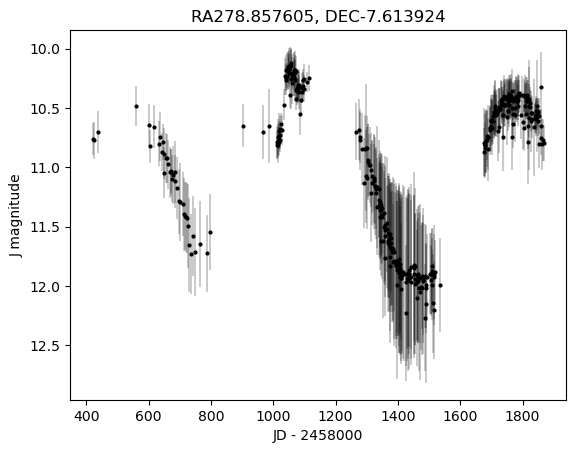

In [18]:
#name light curve file
lcfilename = lcfiledir + 'lightcurve_fid%s_q%s_sq%s_id%d.pdf'%(fieldsource, quadsource, subquadsource, sourceid)

#plot and save figure
plt.figure()

plt.errorbar(jd, mag, yerr=goodmagerr, fmt='.', color='k', elinewidth=0.3, ms=4, ls='')
plt.xlabel('JD - 2458000')
plt.ylabel('J magnitude')
plt.title('RA%.6f, DEC%.6f' % (float(racat), float(deccat)))
plt.gca().invert_yaxis()
plt.savefig(lcfilename)
print('created lc file for ra%.3f dec%.3f, file %s' % (ra, dec, lcfilename))
plt.show()